In [5]:
import numpy as np
import torch
import os

def generate_sine_wave(shape, frequency, amplitude, phase):
    
    """Generate a 3D sine wave pattern."""
    x = np.linspace(0, 2 * np.pi, shape[0])
    y = np.linspace(0, 2 * np.pi, shape[1])
    z = np.linspace(0, 2 * np.pi, shape[2])
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    sine_wave = amplitude * np.sin(frequency * (X + Y + Z) + phase)
    return sine_wave

def generate_linear_gradient(shape, start, end):

    """Generate a 3D linear gradient pattern."""
    gradient = np.linspace(start, end, num=shape[0])
    gradient = np.expand_dims(np.tile(gradient, (shape[1], shape[2], 1)).T,-1)
    gradient = np.repeat(gradient, 3, axis=-1)
    return gradient

def add_noise(data, noise_level):

    """Add random noise to the data."""
    noise = noise_level * np.random.randn(*data.shape)
    return data + noise
    
def generate_fluid_field(shape, reynolds_number=3000, num_steps=10):
    """Generate a simplified 3D fluid velocity field using basic fluid dynamics."""
    
    dx = 1 / shape[0]
    dt = 0.0003
    viscosity = 1.0 / reynolds_number
    boundary_thickness = 2
    
    # Initialize coordinates
    x = np.linspace(-1, 1, shape[0])
    y = np.linspace(-1, 1, shape[1])
    z = np.linspace(-1, 1, shape[2])
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    # Initialize velocity components
    r = np.sqrt((X-0.2)**2 + (Y-0.2)**2 + Z**2)
    vortex_strength = 0.01
    u = -vortex_strength * Y / (r + 0.000001)
    v = vortex_strength * X / (r + 0.000001)
    w = np.zeros_like(u)
    r = np.sqrt((X-0.2)**2 + (Y-0.2)**2 + (Z-0.8)**2)
    u += vortex_strength * Y / (r + 0.000001)
    v += vortex_strength * X / (r + 0.000001)
    w = np.zeros_like(u)
    
    perturbation_strength = 0.00001
    u += np.random.randn(*shape) * perturbation_strength
    v += np.random.randn(*shape) * perturbation_strength
    w += np.random.randn(*shape) * perturbation_strength
    
    # Αποθήκευση της εξέλιξης
    evolution = []
    evolution.append(np.stack([u.copy(), v.copy(), w.copy()], axis=-1))
    
    # Time evolution
    for _ in range(num_steps):
        # Εφαρμογή συνοριακών συνθηκών
        for field in [u, v, w]:
            field[:boundary_thickness, :, :] = 0
            field[-boundary_thickness:, :, :] = 0
            field[:, :boundary_thickness, :] = 0
            field[:, -boundary_thickness:, :] = 0
            field[:, :, :boundary_thickness] = 0
            field[:, :, -boundary_thickness:] = 0
        
        # Υπολογισμός παραγώγων και πίεσης
        du_dx = np.gradient(u, dx, axis=0)
        dv_dy = np.gradient(v, dx, axis=1)
        dw_dz = np.gradient(w, dx, axis=2)
        
        div = du_dx + dv_dy + dw_dz
        p = np.zeros_like(u)
        
        for _ in range(5):
            p = p - 0.1 * div
        
        # Ενημέρωση πεδίων ταχύτητας
        u = u + dt * (viscosity * np.gradient(np.gradient(u, dx, axis=0), dx, axis=0) - np.gradient(p, dx, axis=0))
        v = v + dt * (viscosity * np.gradient(np.gradient(v, dx, axis=1), dx, axis=1) - np.gradient(p, dx, axis=1))
        w = w + dt * (viscosity * np.gradient(np.gradient(w, dx, axis=2), dx, axis=2) - np.gradient(p, dx, axis=2))
        
        # Αποθήκευση τρέχουσας κατάστασης
        evolution.append(np.stack([u.copy(), v.copy(), w.copy()], axis=-1))
    
    return np.array(evolution)  # Shape: (num_steps+1, *shape, 3)

def generate_synthetic_data(shape, num_samples, num_steps=10, noise_level=0.05):
    """Generate synthetic 3D CFD data with fluid-like patterns."""
    data = []
    for _ in range(num_samples):
        reynolds = np.random.uniform(50, 500)
        fluid_evolution = generate_fluid_field(shape, reynolds, num_steps)
        noisy_evolution = add_noise(fluid_evolution, noise_level)
        data.append(noisy_evolution)
    
    return np.array(data)  # Shape: (num_samples, num_steps+1, *shape, 3)


# Parameters
shape = (80, 80, 80)
num_samples = 1
num_steps = 300
noise_level = 0.0
output_directory = "synthetic_cfd_data"
file_prefix = "sample"

# Generate and save data
synthetic_data = generate_synthetic_data(shape, num_samples, num_steps, noise_level)

print(f"Generated and saved {num_samples} samples with {num_steps+1} timesteps each in '{output_directory}' directory.")

def generate_synthetic_data(shape, num_samples, noise_level=0.05):
    """Generate synthetic 3D CFD data with fluid-like patterns."""
    data = []
    for _ in range(num_samples):
        # Generate base fluid field
        reynolds = np.random.uniform(50, 500)  # Random Reynolds number
        fluid_field = generate_fluid_field(shape, reynolds)
        
        # Add noise
        noisy_field = add_noise(fluid_field, noise_level)
        data.append(noisy_field)
    
    return np.array(data)

def save_data_as_pt(data, directory, prefix):

    """Save the generated data as .pt files."""
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i, sample in enumerate(data):
        tensor = torch.from_numpy(sample).float()
        torch.save(tensor, os.path.join(directory, f"{prefix}_{i}.pt"))

# Parameters
shape = (80, 80, 80)
num_samples = 1
noise_level = 0.0
output_directory = "synthetic_cfd_data"
file_prefix = "sample"

# Generate and save data
synthetic_data = generate_synthetic_data(shape, num_samples, noise_level)
save_data_as_pt(synthetic_data, output_directory, file_prefix)

print(f"Generated and saved {num_samples} samples in '{output_directory}' directory.")

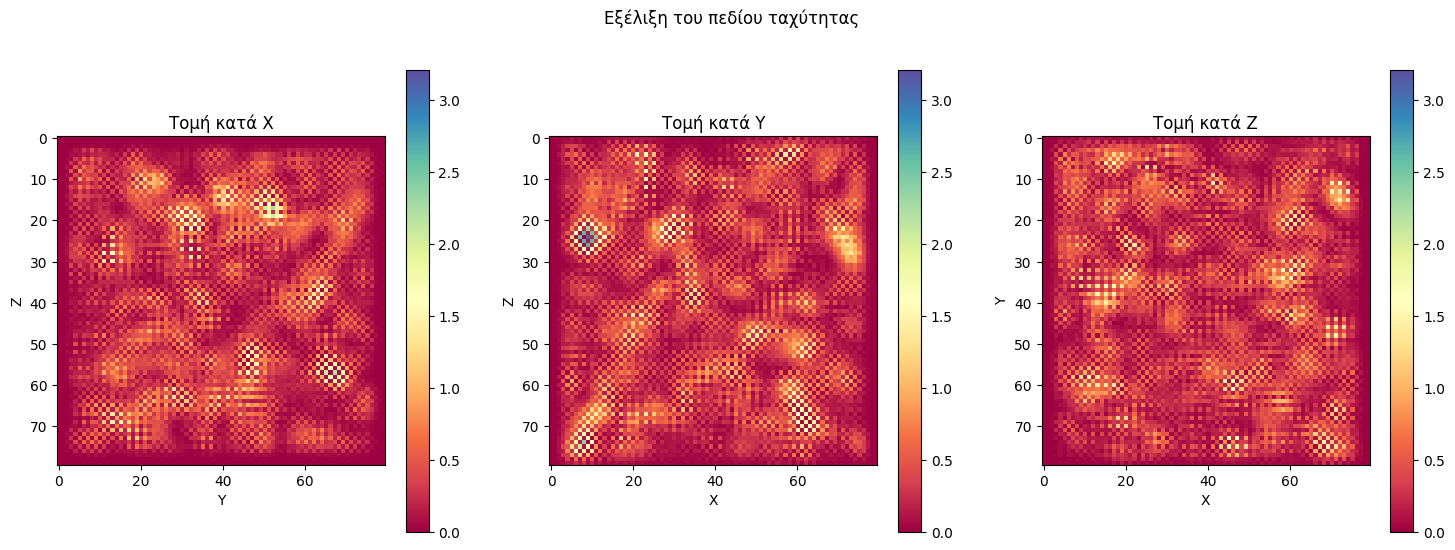

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

# Δημιουργία figure και αξόνων
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Εξέλιξη του πεδίου ταχύτητας')

# Αρχικοποίηση των plots
slices = [shape[0] // 2, shape[1] // 2, shape[2] // 2]
images = []
for ax in axes:
    im = ax.imshow(np.zeros((shape[0], shape[1])), cmap='Spectral')
    plt.colorbar(im, ax=ax)
    images.append(im)

# Ορισμός τίτλων και ετικετών
axes[0].set_title('Τομή κατά X')
axes[0].set_xlabel('Y')
axes[0].set_ylabel('Z')

axes[1].set_title('Τομή κατά Y')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Z')

axes[2].set_title('Τομή κατά Z')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')

# Συνάρτηση ανανέωσης για το animation
def update(frame):
    # Υπολογισμός μεγέθους ταχύτητας για το τρέχον καρέ
    sample = synthetic_data[0, frame]
    velocity_magnitude = sample[..., 0]**2 + sample[..., 1]**2 + sample[..., 2]**2
    
    # Ενημέρωση των plots
    images[0].set_array(velocity_magnitude[slices[0], :, :])
    images[1].set_array(velocity_magnitude[:, slices[1], :])
    images[2].set_array(velocity_magnitude[:, :, slices[2]])
    
    # Δυναμική προσαρμογή του colorbar
    vmin = velocity_magnitude.min()
    vmax = velocity_magnitude.max()
    for im in images:
        im.set_clim(vmin, vmax)
    
    return images

# Δημιουργία του animation
anim = FuncAnimation(fig, update, frames=synthetic_data.shape[1], 
                    interval=200, blit=True)

# Αποθήκευση του animation
anim.save('velocity_field_evolution.gif', writer='pillow')

plt.show()

In [3]:
from tqdm import tqdm
import torch
from torch.nn import functional as F
import numpy as np
import pdb

def schedule_KL_annealing(start, stop, n_epochs, n_cycle=4, ratio=0.5):
    """
    Custom function for multiple annealing scheduling: Monotonic and cyclical_annealing
    Given number of epochs, it returns the value of the KL weight at each epoch as a list.

    Based on from: https://github.com/haofuml/cyclical_annealing/blob/master/plot/plot_schedules.ipynb
    """

    weights = np.ones(n_epochs)
    period = n_epochs/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):
        v , i = start , 0
        while v <= stop and (int(i+c*period) < n_epochs):
            weights[int(i+c*period)] = v
            v += step
            i += 1

    return weights

def loss_function(recon_x, x, mu, logvar, kl_weight):
    
    """
    Computes binary cross entropy and analytical expression of KL divergence used to train Variational Autoencoders

    Losses are calculated per batch (recon vs original). Their sizes are torch.Size([128, 3, 21, 21, 21])

    Total loss is reconstruction + KL divergence summed over batch
    """
    
    # reconstruction loss (MSE/BCE for image-like data)
    # CE = torch.nn.CrossEntropyLoss()(recon_x, x)
    # MSE = torch.nn.MSELoss(reduction='mean')(recon_x, x)
    MSE = 0.1 * torch.nn.MSELoss(reduction='sum')(recon_x, x)
    # BCE = F.binary_cross_entropy(recon_x, x, reduction="mean") # only takes data in range [0, 1]
    # BCEL = torch.nn.BCEWithLogitsLoss(reduction="mean")(recon_x, x)

    # KL divergence loss (with annealing)
    # KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) # sum or mean
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # KLD = KLD * kl_weight

    return MSE + KLD, MSE, KLD


def train(epoch, model, train_loader, kl_weight, optimizer, device, scheduler, args):
    """
    Mini-batch training.
    """

    model.train()
    train_total_loss = 0
    train_BCE_loss = 0
    train_KLD_loss = 0

    print("entered batch training")
    print("train device:", device)
    for batch_idx, data in tqdm(enumerate(train_loader), total=len(train_loader), desc='train'):

        # move data into GPU tensors
        data = data.to(device, dtype=torch.float)

        # reset gradients
        optimizer.zero_grad()

        # call CVAE model
        # feeding 3D volume to Conv3D: https://discuss.pytorch.org/t/feeding-3d-volumes-to-conv3d/32378/6
        recon_batch, mu, logvar, _ = model(data)

        # compute batch losses
        total_loss, BCE_loss, KLD_loss = loss_function(recon_batch, data, mu, logvar, kl_weight)

        train_total_loss += total_loss.item()
        train_BCE_loss += BCE_loss.item()
        train_KLD_loss += KLD_loss.item()

        # compute gradients and update weights
        total_loss.backward()
        optimizer.step()

        # schedule learning rate
        scheduler.step()

    train_total_loss /= len(train_loader.dataset)
    train_BCE_loss /= len(train_loader.dataset)
    train_KLD_loss /= len(train_loader.dataset)

    return train_total_loss, train_BCE_loss, train_KLD_loss

In [4]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import Field3DDataset
from models import CVAE_3D
from utils import init_weights
# from torch.utils.tensorboard import SummaryWriter

# Set variables
result_dir = 'results'
seed = 1
batch_size = 32
epochs = 100
h_dim = 128
z_dim = 64
test_every_epochs = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

data_dir = r'C:\Users\apost\OneDrive\Documents\GitHub\Convolutional-VAE-for-3D-Turbulence-Data\synthetic_cfd_data'

# Create results directory
os.makedirs(result_dir, exist_ok=True)

# Simulation parameters
no_simulations = 96  # individual npy files
simulation_timesteps = 100  # time steps per simulation
IMG_DIM = 21  # cube dimensions
cube_channels = 3  # 3 velocity components (analogue to RGB)

# Define transforms
transformations = transforms.Compose([transforms.ToTensor()])

# Define custom 3D dataset
CFD_3D_dataset = Field3DDataset(data_dir)

# Split train, validation sets
train_set, val_set = torch.utils.data.random_split(CFD_3D_dataset,
                                                   [int(len(CFD_3D_dataset) * 0.7),
                                                    int(len(CFD_3D_dataset) * 0.3)])

# Create data loaders
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

# Instantiate model and initialize network weights
model = CVAE_3D(image_channels=cube_channels, h_dim=h_dim, z_dim=z_dim).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader))

# Initialize SummaryWriter for TensorBoard

# Schedule KL annealing
def schedule_KL_annealing(start, end, epochs, cycle_length):

    kl_weights = []
    for epoch in range(epochs):
        cycle_position = (epoch % cycle_length) / cycle_length
        kl_weight = start + (end - start) * cycle_position
        kl_weights.append(kl_weight)
    return kl_weights

kl_weights = schedule_KL_annealing(0.0, 1.0, epochs, 4)  # cyclical annealing

# Training loop
for epoch in range(epochs):
    print(f"[INFO] Epoch {epoch}")
    kl_weight = kl_weights[epoch]
    print("current KL weight:", kl_weight)
    train_total_loss, train_BCE_loss, train_KLD_loss = train(epoch, model, train_loader, kl_weight, optimizer, device, scheduler, None)
    print(f"Epoch [{epoch}/{epochs}] train_total_loss: {train_total_loss:.3f}, train_REC_loss: {train_BCE_loss:.3f}, train_KLD_loss: {train_KLD_loss:.3f}")

print("[INFO] Training completed")

[INFO] started instantiating 3D CFD pytorch dataset


c:\Users\apost\OneDrive\Documents\GitHub\Convolutional-VAE-for-3D-Turbulence-Data\datasets.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_cube = torch.load(data_f

RuntimeError: The size of tensor a (21) must match the size of tensor b (80) at non-singleton dimension 3